In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


#load in cleaned and transformed data file
df = pd.read_csv("Data\Export\central_dem_grades_clean.csv")

#convert date of birth column from str to datetime type, extract year, drop date column
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], format = '%Y-%m-%d')
df['Birth_Year'] = df['Date_of_Birth'].dt.year
df = df.drop('Date_of_Birth', axis = 1)

#show first 5 rows
#df.head()


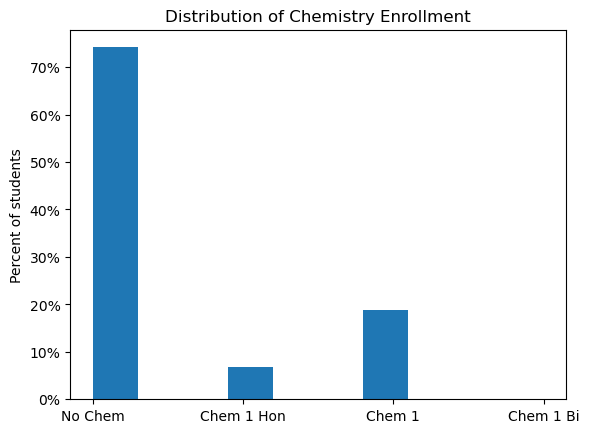

In [4]:
chem_enroll = df['chem11'].replace({0: 'No Chem',  1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
chem_enroll

plt.hist(chem_enroll, weights=np.ones(len(chem_enroll)) / len(chem_enroll))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title("Distribution of Chemistry Enrollment")
plt.ylabel("Percent of students")

plt.show()

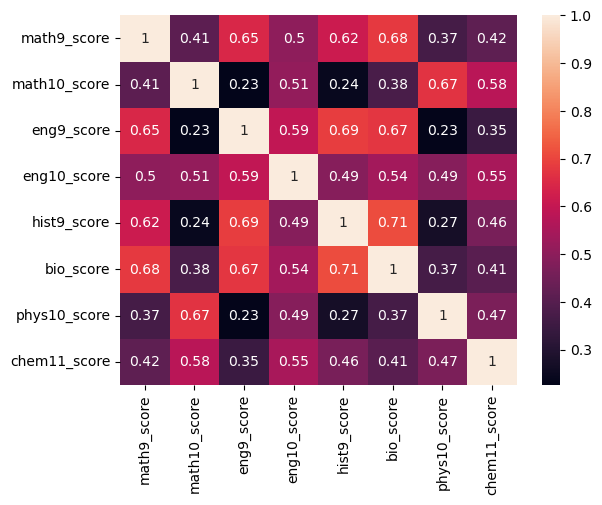

In [13]:
import seaborn as sn 
core_courses = ['math9_score', 'math10_score', 'eng9_score', 'eng10_score', 
                'hist9_score', 'bio_score', 'phys10_score', 'chem11_score']

corr_matrix = df[core_courses].corr()
#corr_matrix['chem11_score']

sn.heatmap(corr_matrix, annot=True)
plt.show()

Text(0.5, 1.0, 'Chem scores based on attributes')

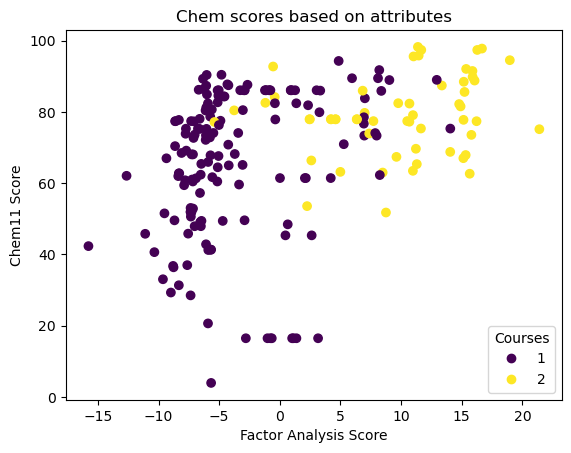

In [14]:
#dimensionality reduction to plot chem scores vs other factors
#Factor analysis of mixed data https://pypi.org/project/prince/0.7.1/
from prince import FAMD

#drop NaN 
FAMD_df = df.dropna()

#drop chem course and score columns
FAMD_df2 = FAMD_df.drop(['chem11', 'chem11_score'], axis='columns')

#set up FAMD method
famd = FAMD(
     n_components=1,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='sklearn',
     random_state=42
)

famd =famd.fit(FAMD_df)

FAMD_1D = famd.row_coordinates(FAMD_df)

#create graph of reduced component and chem score with colors for courses
fig, ax = plt.subplots()
labels = {1: 'Chem 1', 2: 'Chem 1 Hon'}
scatter = ax.scatter(FAMD_1D, FAMD_df['chem11_score'], 
            c=FAMD_df['chem11'])

#create legend
legend = ax.legend(*scatter.legend_elements(),
                   title = 'Courses', 
                   loc = 'lower right')

#Add labels to graph 
plt.xlabel('Factor Analysis Score')
plt.ylabel('Chem11 Score')
plt.title("Chem scores based on attributes")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#create list of categorical features
category_features = ['Gender', 'Counselor', 'ELL_Status', 'schoolName']

#use one hot encoder method to create an array of encoded data
ohn_data = pd.DataFrame(ohe.fit_transform(df[category_features]).toarray())

#create a dictionary of the encoded columns with meaningful names
ohn_columns = {0: 'Female', 1: 'Male', 2: 'Counselor10', 3: 'Counselor13', 4: 'Counselor16', 5: 'Counselor16', 6: 'Counselor19',
               7: 'Counselor22', 8: 'Counselor25', 9: 'Counselor28', 10: 'Counselor31', 11: 'Counselor34', 12: 'Counselor37', 
               13: 'Non-ELL', 14: 'ELL'}

#replace the column names with meaningful names
ohn_data = ohn_data.rename(columns=ohn_columns)

#create new df by joining categorical data array with non categorical array 
new_df = df.join(ohn_data)

#drop non encoded categorical data
new_df = new_df.drop(category_features, axis=1)

#drop all missing values 
new_df = new_df.dropna()

#create new idexes
new_df = new_df.set_index('ID')

new_df.head()


In [34]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Create feature and target arrays
X = new_df.drop(['chem11', 'chem11_score'], axis=1)
X = X.values
y = new_df['chem11']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)
  
knn = KNeighborsClassifier(n_neighbors=3)
  
knn.fit(X_train, y_train)
  
# Predict on dataset which model has not seen before
pred =knn.predict(X_test) 

#print statistics to measure the model's performance 
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Confusion Matrix: \n", confusion_matrix(y_test, pred))
print("Accuracy Score:", accuracy_score(pred,y_test))
print("Precision:", precision_score(pred, y_test))
print("Recall:", recall_score(pred, y_test))


Confusion Matrix: 
 [[28  5]
 [ 9  1]]
Accuracy Score: 0.6744186046511628
Precision: 0.8484848484848485
Recall: 0.7567567567567568
